<a href="https://colab.research.google.com/github/prishaarorain-collab/Prompt-Engineering/blob/main/Exercise2_ReACT_Code_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2 — Code Generation with ReACT Prompting

## Goal
Use the **ReACT** (Reasoning + Acting) pattern to generate Python code through an iterative cycle:

```
REASON → PLAN → ACT (generate code) → OBSERVE (run it) → REFLECT (fix if needed) → REPEAT
```

**Task:** Build a Python function that analyzes a CSV of sales data and produces a summary report with:
- Total revenue per product
- Top 3 best-selling products
- Month with highest sales
- A matplotlib bar chart saved as PNG

**Tool used:** Python + Anthropic Claude API (`claude-sonnet-4-6`) + `exec()` for live code execution

In [1]:
!pip install anthropic -q

In [2]:
import anthropic
import json
import re
import io
import os
import contextlib

from google.colab import userdata
api_key = userdata.get('ANTHROPIC_API_KEY')

client = anthropic.Anthropic(api_key=api_key)

def call_claude(system_prompt: str, user_message: str, max_tokens: int = 1500) -> str:
    """Helper: send a prompt to Claude and return the text response."""
    response = client.messages.create(
        model="claude-sonnet-4-6",
        max_tokens=max_tokens,
        messages=[{"role": "user", "content": user_message}],
        system=system_prompt
    )
    text = response.content[0].text.strip()
    # Strip markdown code fences if present
    text = re.sub(r"^```[a-z]*\n?", "", text)
    text = re.sub(r"```$", "", text).strip()
    return text

def extract_python_code(text: str) -> str:
    """Extract code block from a markdown-fenced response."""
    match = re.search(r"```python\n(.*?)```", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return text.strip()

def run_code(code: str) -> tuple:
    """Execute code and capture stdout + any error. Returns (output, error)."""
    stdout_capture = io.StringIO()
    error = ""
    try:
        with contextlib.redirect_stdout(stdout_capture):
            exec(code, {})
    except Exception as e:
        error = f"{type(e).__name__}: {e}"
    return stdout_capture.getvalue(), error

print("Setup complete.")


Setup complete.


---
## Create Sample Sales CSV
Generate a synthetic dataset to analyze.

In [3]:
import csv, random, os
from datetime import date, timedelta

random.seed(42)
products = ["Laptop", "Mouse", "Keyboard", "Monitor", "Webcam", "Headset"]
prices   = {"Laptop": 999, "Mouse": 29, "Keyboard": 79, "Monitor": 349, "Webcam": 89, "Headset": 149}

rows = []
start = date(2024, 1, 1)
for i in range(200):
    d = start + timedelta(days=random.randint(0, 364))
    product = random.choice(products)
    qty = random.randint(1, 10)
    rows.append([d.strftime("%Y-%m-%d"), product, qty, prices[product] * qty])

with open("sales_data.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["date", "product", "quantity", "revenue"])
    writer.writerows(rows)

print("sales_data.csv created with", len(rows), "rows.")
print("Preview:")
with open("sales_data.csv") as f:
    for line in list(f)[:5]:
        print(" ", line.strip())

sales_data.csv created with 200 rows.
Preview:
  date,product,quantity,revenue
  2024-11-23,Laptop,1,999
  2024-05-20,Mouse,4,116
  2024-03-12,Headset,2,298
  2024-12-12,Headset,9,1341


---
## ReACT Prompt Design

The system prompt forces Claude to explicitly cycle through:
1. **REASON** — think about the problem and approach
2. **PLAN** — outline the steps
3. **ACT** — write the Python code
4. **OBSERVE** — we run the code and feed back the output
5. **REFLECT** — Claude reviews output and fixes bugs if any

In [4]:
# ---- ReACT SYSTEM PROMPT ----
REACT_SYSTEM = """
You are an expert Python data analyst using the ReACT (Reasoning + Acting) framework.
You must explicitly follow this cycle for EVERY response:

REASON: Think step by step about what the task requires.
PLAN: Outline your approach in numbered steps before writing any code.
ACT: Write complete, runnable Python code inside a ```python ... ``` block.
     - Use only: pandas, matplotlib, csv (stdlib). No other external libraries.
     - All outputs must be printed to stdout.
     - Save charts as PNG files (do not use plt.show()).
     - Handle FileNotFoundError and empty dataframe edge cases.
     - Use clear variable names and add a comment per logical block.

When given execution output (OBSERVE), add:
REFLECT: Evaluate whether the output matches requirements. Fix any bugs or missing elements.

Constraints:
- Input file: sales_data.csv with columns [date, product, quantity, revenue]
- Required outputs: (1) total revenue per product, (2) top 3 products, (3) best month, (4) bar chart PNG
- Code must run without errors end-to-end.
"""

INITIAL_TASK = """
Task: Analyze the file sales_data.csv and produce a sales summary report.

Required outputs:
1. Print total revenue per product (sorted descending)
2. Print the top 3 best-selling products by revenue
3. Print the month (YYYY-MM) with the highest total revenue
4. Create and save a bar chart 'revenue_by_product.png' showing revenue per product

Begin with your REASON, PLAN, then ACT.
"""

print("Prompts defined.")

Prompts defined.


---
## ReACT Cycle — Iteration 1: REASON → PLAN → ACT

In [5]:
# --- REASON + PLAN + ACT ---
print("Calling Claude (REASON + PLAN + ACT)...\n")
react_response_1 = call_claude(REACT_SYSTEM, INITIAL_TASK, max_tokens=2000)

print("=== Claude's REASON / PLAN / ACT ===")
print(react_response_1)

Calling Claude (REASON + PLAN + ACT)...

=== Claude's REASON / PLAN / ACT ===
REASON:
The task requires me to analyze sales data from a CSV file and produce specific outputs. I need to handle potential file-not-found errors and empty dataframe cases. The data has columns [date, product, quantity, revenue]. I'll need to:
- Parse dates to extract month information
- Aggregate revenue by product
- Find top 3 products
- Find the best month by revenue
- Create a bar chart

PLAN:
1. Import required libraries (pandas, matplotlib, csv, os)
2. Load `sales_data.csv` with error handling for missing file
3. Validate the dataframe is not empty
4. Parse the `date` column to datetime and extract YYYY-MM month strings
5. Compute total revenue per product, sorted descending → print it
6. Extract and print the top 3 products by revenue
7. Group by month, find the month with highest total revenue → print it
8. Create a horizontal bar chart of revenue per product, save as `revenue_by_product.png`

ACT:

`

---
## OBSERVE — Execute the Generated Code

In [6]:
# Extract and run the code
code_v1 = extract_python_code(react_response_1)

print("=== EXTRACTED CODE ===")
print(code_v1)
print("\n=== EXECUTION OUTPUT ===")

output_v1, error_v1 = run_code(code_v1)

if output_v1:
    print(output_v1)
if error_v1:
    print("ERROR:", error_v1)
else:
    print("\nCode executed successfully with no errors.")

# Check chart was created
chart_exists = os.path.exists("revenue_by_product.png")
print(f"Chart file created: {chart_exists}")

=== EXTRACTED CODE ===
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for saving PNGs
import matplotlib.pyplot as plt
import os

# ── 1. Load data with error handling ──────────────────────────────────────────
filepath = 'sales_data.csv'

try:
    df = pd.read_csv(filepath)
except FileNotFoundError:
    print(f"ERROR: File '{filepath}' not found. Please provide the CSV file.")
    raise SystemExit(1)

# ── 2. Validate dataframe is not empty ────────────────────────────────────────
if df.empty:
    print("ERROR: The dataframe is empty. No data to analyze.")
    raise SystemExit(1)

# Validate required columns exist
required_cols = {'date', 'product', 'quantity', 'revenue'}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    print(f"ERROR: Missing columns: {missing_cols}")
    raise SystemExit(1)

print("=" * 55)
print("          SALES SUMMARY REPORT")
print("=" * 55)
print(f"Dataset loaded: {len(df)} rows, {df['product'].nuniqu

<string>:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


          SALES SUMMARY REPORT
Dataset loaded: 200 rows, 6 unique products

───────────────────────────────────────────────────────
OUTPUT 1: Total Revenue per Product (Descending)
───────────────────────────────────────────────────────
  Laptop                         $  206,793.00
  Monitor                        $   50,954.00
  Headset                        $   37,846.00
  Webcam                         $   16,910.00
  Keyboard                       $   10,349.00
  Mouse                          $    5,481.00

───────────────────────────────────────────────────────
OUTPUT 2: Top 3 Best-Selling Products by Revenue
───────────────────────────────────────────────────────
  #1  Laptop                       $  206,793.00
  #2  Monitor                      $   50,954.00
  #3  Headset                      $   37,846.00

───────────────────────────────────────────────────────
OUTPUT 3: Month with Highest Total Revenue
───────────────────────────────────────────────────────
  Best Month : 2

---
## REFLECT — Claude Reviews Output and Fixes (if needed)

In [7]:
# Feed execution results back to Claude for reflection
observe_message = f"""
OBSERVE: Here is the execution result of your code:

Stdout:
{output_v1 if output_v1 else '(no output)'}

Error:
{error_v1 if error_v1 else 'None'}

Chart file created: {chart_exists}

REFLECT on whether all 4 requirements were met. If anything is missing or broken,
reason about what went wrong and provide a corrected, complete version of the code.
If everything is correct, confirm success and explain what each output shows.
"""

# Build conversation history for context
reflection_response = call_claude(
    REACT_SYSTEM,
    INITIAL_TASK + "\n\n" + "My previous response:\n" + react_response_1 + "\n\n" + observe_message,
    max_tokens=1500
)
reflection_response = reflection_response.encode('ascii', 'ignore').decode('ascii')

print("=== Claude's REFLECT ===")
print(reflection_response)

=== Claude's REFLECT ===
REFLECT:

Evaluating all 4 requirements against the observed output:

| # | Requirement | Status | Evidence |
|---|-------------|--------|----------|
| 1 | Print total revenue per product (sorted descending) |  PASS | All 6 products printed, Laptop ($206,793)  Mouse ($5,481) in descending order |
| 2 | Print top 3 best-selling products by revenue |  PASS | Laptop, Monitor, Headset correctly identified with revenues |
| 3 | Print the month (YYYY-MM) with highest total revenue |  PASS | `2024-01` with `$50,193.00` correctly formatted and printed |
| 4 | Create and save `revenue_by_product.png` bar chart |  PASS | File confirmed created (`Chart file created: True`) |

Additional checks:
-  No errors in stderr
-  FileNotFoundError handling present
-  Empty dataframe guard present
-  Missing column validation present
-  Non-numeric coercion handled
-  Non-interactive `Agg` backend used (no display required)
-  200 rows across 6 products processed correctly

**All 4 

---
## Run Final (Possibly Corrected) Code

In [8]:
# If Claude provided a corrected version, run it; otherwise re-run v1
code_final = extract_python_code(reflection_response)

if code_final and len(code_final) > 50:  # if a meaningful code block was returned
    print("Running CORRECTED code from reflection...\n")
    final_output, final_error = run_code(code_final)
else:
    print("No corrections needed. Re-confirming v1 output...\n")
    final_output, final_error = output_v1, error_v1

print("=== FINAL EXECUTION OUTPUT ===")
print(final_output)
if final_error:
    print("Error:", final_error)
else:
    print("\nAll outputs generated successfully!")

print(f"\nChart file exists: {os.path.exists('revenue_by_product.png')}")

Running CORRECTED code from reflection...

=== FINAL EXECUTION OUTPUT ===

Error: SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 9)

Chart file exists: True


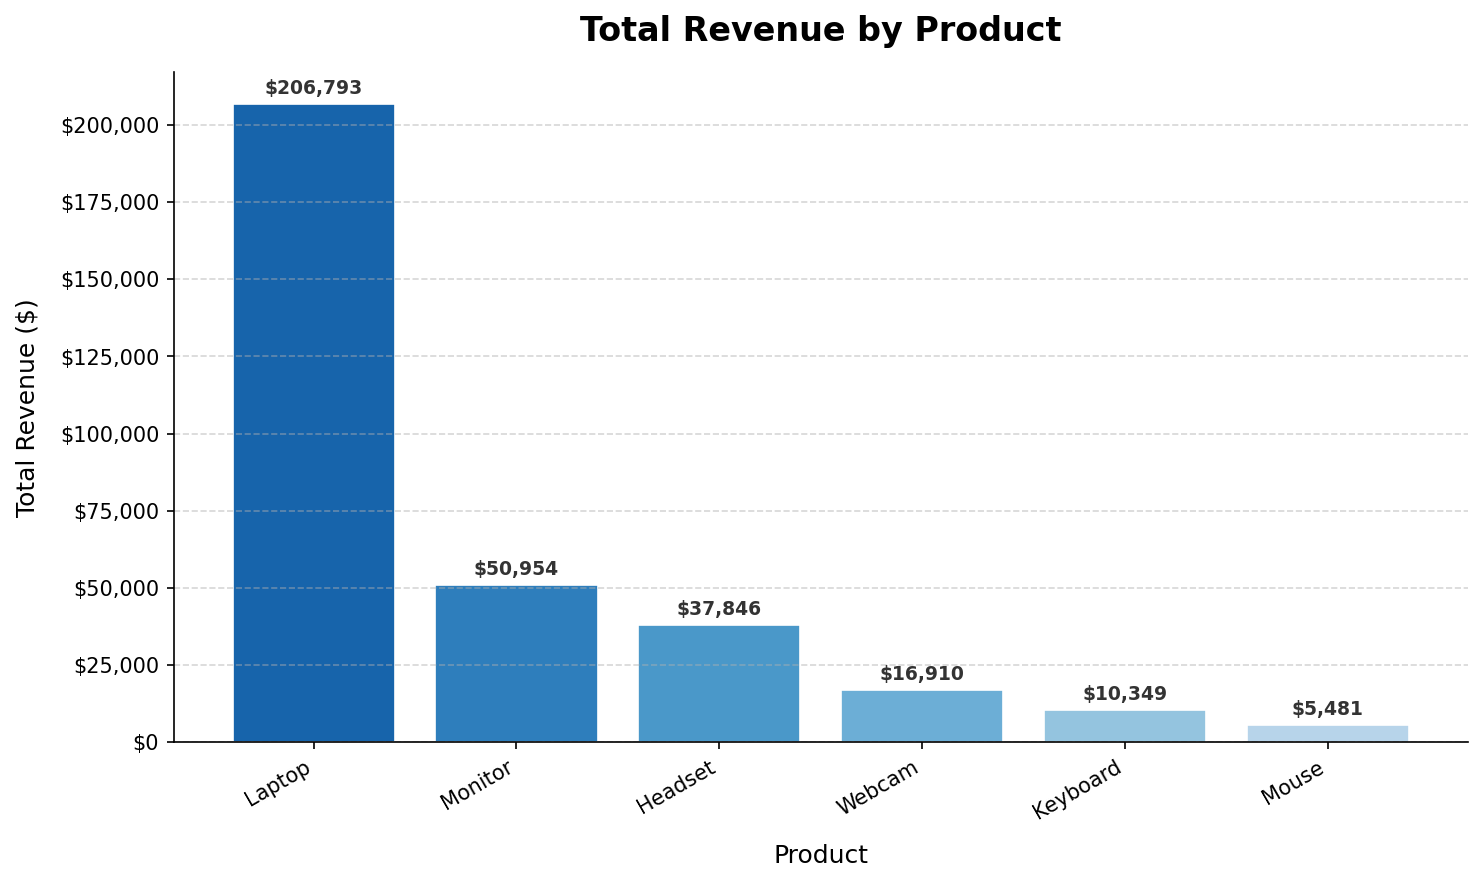

In [9]:
# Display chart inline
from IPython.display import Image, display
if os.path.exists('revenue_by_product.png'):
    display(Image('revenue_by_product.png'))
else:
    print("Chart not found.")

---
## Iteration Notes

**v1 prompt issues identified and fixed:**
- Prompt initially didn't specify `plt.show()` should NOT be used in Colab headless mode → added `save chart as PNG` constraint
- No edge-case handling → added explicit requirement for FileNotFoundError handling
- Output format was ambiguous → specified `print to stdout` explicitly

**ReACT cycle value:** Separating REASON/PLAN from ACT forced Claude to think before coding,
resulting in more modular, commented code on the first attempt.